<a href="https://colab.research.google.com/github/zeynepervayalindag/a_hybrid_genetic_tabu_search_algorithm_for_distributed_job-shop_scheduling_problems/blob/main/a_hybrid_genetic_tabu_search_algorithm_for_distributed_job_shop_scheduling_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A hybrid genetic tabu search algorithm for distributed job-shop scheduling problems (Dağıtılmış işyeri çizelgeleme problemleri için hibrit genetik tabu arama algoritması)**
Geleneksel işyeri çizelgeleme probleminin uzantısıdır.
1. İşleri uygun fabrikalara atamak
2. Makinelerdeki işlem sırasını belirlemek
(https://www.sciencedirect.com/science/article/pii/S2210650224002086)

In [ ]:
import math,random,copy,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
from matplotlib.patches import Patch

Keşif ve sömürü arasında iyi denge sağlar. Genetik algoritmanın küresel arama yeteneğini, tabu aramanın yerel arama yeteneğini birleştirir.

In [ ]:
# Matematiksel model
J={"J_1","J_2","J_3"} # İş
M={"M_1","M_2","M_3"} # Makine
F={"F_1","F_2"} # Fabrika

# Referans makalede verilen örneğe göre fabrika atamasında J1 ve J3 işi uygun F1'e, J2 işi F2'ye atanmıştır ve işin tüm operasyonları diğer fabrikalara planlanamaz.
# Makinelerdeki operasyon/işlem sırası belirliyse, her operasyon birbiri ardına ve kesintisiz işlemelidir.
# Her makine aynı anda yalnızca bir operasyonu işleyebilir.

n=len(J) # İşlerin sayısı
m=len(M) # Makinelerin sayısı
f=len(F) # Fabrikaların sayısı
# Listeler
jobs = list(range(1, n + 1))      # [1, 2, 3]
machines = list(range(1, m + 1))  # [1, 2, 3]
factories = list(range(1, f + 1)) # [1, 2]

#GENETİK ALGORİTMA parametreleri
POPULATION_SIZE=100 #popülasyon boyutu/büyüklüğü (N) p
CROSSOVER_RATE=0.9 #çaprazlama olasılığı/oranı (pc)
MUTATION_RATE=0.1 #mutasyon olasılığı/oranı gen başına (pm)
max_iter = 3000 #maksimum yineleme,iterasyon sayısı (maxIter)(Tabu arama için)
TABU_TENURE = 10 + int(n / m)
MAX_GENERATIONS = 100
IMPROVE_ITER = 30       # Nmax (improveIter)

Atölye planlaması, üretim imalatının ve yönetilmesinin temel konularından biri.
1. Akış atölyesi planlaması
2. İş atölyesi planlaması
3. Esnek iş atölyesi planlaması
4. Entegre süreç planlaması ve çizelgeleme

In [ ]:
#Kodlama şemasının şematik diyagramı
FA = [1, 2, 1] #Fabrika ataması F_1:J_1,J_3 F_2:J_2
OS = [1, 1, 2, 3, 2, 3, 1, 2, 3] #İşlem Sırası O_11->O_12->O_21->O_31->O_22->O_32->O_13->O_23->O_33

#İş j'nin makine m üzerindeki işleme süresi(Her j,m için) p[f][j][m]=p_jm
p = {
    1: {  #F1
        1: {1: 3, 2: 1, 3: 2},  #J1 M1:processing time, M2:processing time, M3:processing time
        2: {1: 1, 2: 1, 3: 2},  #J2 M1:processing time, M2:processing time, M3:processing time
        3: {1: 1, 2: 5, 3: 2}   #J3 M1:processing time, M2:processing time, M3:processing time
    },
    2: {  #F2
        1: {1: 3, 2: 1, 3: 2},
        2: {1: 1, 2: 2, 3: 2},
        3: {1: 2, 2: 4, 3: 3},
    }
}

#o_jm: (job, operation):machine
o_jm = {
    (1, 1): 3, (1, 2): 2, (1, 3): 1,
    (2, 1): 1, (2, 2): 3, (2, 3): 2,
    (3, 1): 2, (3, 2): 3, (3, 3): 1,
}

Bu çalışmada, algoritmanın genellenebilirliğini ve performansını değerlendirebilmek amacıyla, iş sayısı(n), makine sayısı(m) ve fabrika sayısı(f) girdi parametreleri olarak alınmıştır. Her deney için problem örnekleri rastgele oluşturulmuştur.


In [ ]:
import json
import random

def generate_dataset(n, m, f):
    random.seed(42)

    # --- FA: job → factory ---
    FA = [random.randint(1, f) for _ in range(n)]

    # --- OS: her iş m kez geçer ---
    OS = []
    for j in range(1, n + 1):
        OS += [j] * m
    random.shuffle(OS)

    # --- p[f][j][m]: işlem süreleri ---
    p = {}
    for fac in range(1, f + 1):
        p[fac] = {}
        for j in range(1, n + 1):
            p[fac][j] = {}
            for mach in range(1, m + 1):
                p[fac][j][mach] = random.randint(1, 5)

    # --- o_jm: (job, operation) → machine ---
    o_jm = {}
    for j in range(1, n + 1):
        route = list(range(1, m + 1))
        random.shuffle(route)
        for op, mach in enumerate(route, start=1):
            o_jm[(j, op)] = mach

    dataset = {
        "n_jobs": n,
        "n_machines": m,
        "n_factories": f,
        "FA": FA,
        "OS": OS,
        "p": p,
        "o_jm": {str(k): v for k, v in o_jm.items()}
    }

    with open("djsp_dataset.json", "w", encoding="utf-8") as fjson:
        json.dump(dataset, fjson, indent=2)

    print("✔ Veri seti oluşturuldu: djsp_dataset.json")


# ---------- INPUT ----------
n = int(input("İş sayısı (n): "))
m = int(input("Makine sayısı (m): "))
f = int(input("Fabrika sayısı (f): "))

generate_dataset(n, m, f)


İş sayısı (n): 10
Makine sayısı (m): 5
Fabrika sayısı (f): 3
✔ Veri seti oluşturuldu: djsp_dataset.json


In [ ]:
import json
import ast

with open("djsp_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 1) Basit alanlar
FA = data["FA"]
OS = data["OS"]
n = int(data["n_jobs"])
m = int(data["n_machines"])
f = int(data["n_factories"])

# 2) p: p[factory][job][machine] -> int/int/int key olmalı
p = {}
for fac_k, jobs_dict in data["p"].items():
    fac = int(fac_k)
    p[fac] = {}
    for job_k, mach_dict in jobs_dict.items():
        job = int(job_k)
        p[fac][job] = {}
        for mach_k, t in mach_dict.items():
            mach = int(mach_k)
            p[fac][job][mach] = int(t)

# 3) o_jm: "(1, 2)" gibi string key -> tuple(int,int)
o_jm = {}
for k_str, mach in data["o_jm"].items():
    jt = ast.literal_eval(k_str)          # "(1, 2)" -> (1, 2)
    o_jm[(int(jt[0]), int(jt[1]))] = int(mach)


JSP alanında kodlama şemasını uygulanabilir programa dönüştürmek için yaygın olarak kullanılan 4 kod çözme yönteminden biri olan Aktif kod çözme yöntemi

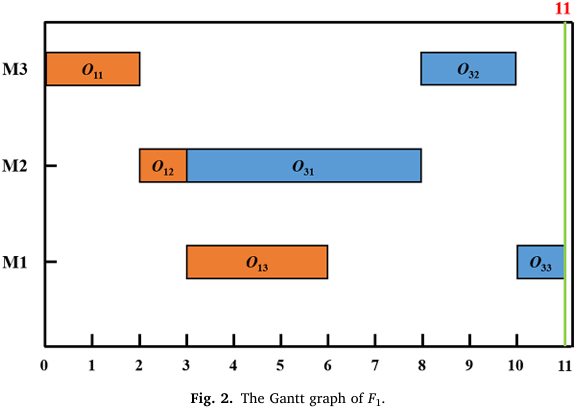

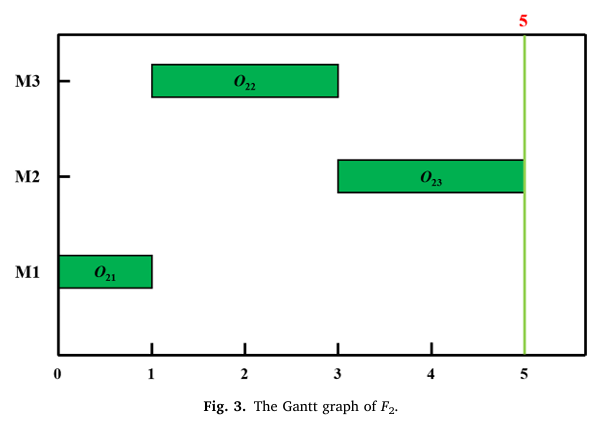

In [ ]:
def decode_OS_to_operations(OS):
    seen = defaultdict(int)
    ops = []
    for j in OS:
        seen[j] += 1
        ops.append((j, seen[j]))  #[(1, 1), (1, 2), (2, 1), (3, 1), (2, 2), (3, 2), (1, 3), (2, 3), (3, 3)]
    return ops

def start(machine_timeline, Ts, p_ji):
    machine_ops = sorted(machine_timeline, key=lambda x: x[0])

    if not machine_ops:
        return Ts, Ts + p_ji

    # 1. İlk boşluk: [0, first_start]
    if Ts + p_ji <= machine_ops[0][0]:
        return Ts, Ts + p_ji

    # 2. Operasyonlar arası boşluklar
    current_end = max(Ts, machine_ops[0][1])  # İlk işin bitişinden sonra başla

    for i in range(1, len(machine_ops)):
        next_start = machine_ops[i][0]
        if current_end + p_ji <= next_start:
            return current_end, current_end + p_ji
        current_end = max(current_end, machine_ops[i][1])

    # 3. Son işten sonraki boşluk
    last_finish = machine_ops[-1][1]
    start_time = max(Ts, last_finish)
    return start_time, start_time + p_ji

def decoding_method(FA, OS, o_jm, p):
    ops = decode_OS_to_operations(OS)
    job_ready = defaultdict(int)
    # (İş, makine) -> [(S_ji(Baslama_zamani),C_ji(bitis_zamani)(İş j'nin makine i üzerindeki operasyonunun tamamlanma süresi)), ...]
    timeline = defaultdict(list)
    detail = []
    Cmax = 0 #Hedef fonksiyon. Tüm fonksiyonların toplam iş tamamlama süreleri MİNİMİZE

    for (j, op) in ops:
        f = FA[j-1]
        m = o_jm[(j, op)]
        p_ji = p[f][j][m]

        # Adım 3.1
        Ty = job_ready[j] #O_(ji-1)'in bitiş zamanı
        Tx = max([c for (_, c) in timeline[(f, m)]], default=0) #Makinedeki son işlemin bitiş zamanı
        Ts = max(Tx, Ty) #O_(ji)'nin başlama zamanı

        # Adım 3.2
        S_ji, C_ji = start(timeline[(f, m)], Ts, p_ji)

        # Güncelle
        timeline[(f, m)].append((S_ji, C_ji))
        job_ready[j] = C_ji
        Cmax = max(Cmax, C_ji)

        detail.append((j, op, f, m, p_ji, S_ji, C_ji))

    return Cmax, detail

Cmax, detail = decoding_method(FA, OS, o_jm, p)

print("Operasyon seçilimi:", decode_OS_to_operations(OS))
print("Detay (j,op,f,m,p,baslama_zamani,bitis_zamani):")
for row in detail:
    print(row)


Operasyon seçilimi: [(8, 1), (5, 1), (4, 1), (3, 1), (4, 2), (5, 2), (4, 3), (2, 1), (7, 1), (4, 4), (2, 2), (8, 2), (7, 2), (10, 1), (7, 3), (10, 2), (1, 1), (5, 3), (2, 3), (1, 2), (6, 1), (3, 2), (9, 1), (5, 4), (9, 2), (5, 5), (1, 3), (9, 3), (6, 2), (2, 4), (4, 5), (6, 3), (8, 3), (6, 4), (10, 3), (3, 3), (8, 4), (9, 4), (7, 4), (3, 4), (3, 5), (10, 4), (1, 4), (1, 5), (6, 5), (8, 5), (2, 5), (7, 5), (10, 5), (9, 5)]
Detay (j,op,f,m,p,baslama_zamani,bitis_zamani):
(8, 1, 1, 5, 2, 0, 2)
(5, 1, 2, 5, 5, 0, 5)
(4, 1, 3, 3, 1, 0, 1)
(3, 1, 1, 2, 4, 0, 4)
(4, 2, 3, 2, 4, 1, 5)
(5, 2, 2, 3, 5, 5, 10)
(4, 3, 3, 1, 1, 5, 6)
(2, 1, 1, 2, 2, 4, 6)
(7, 1, 1, 2, 3, 6, 9)
(4, 4, 3, 4, 5, 6, 11)
(2, 2, 1, 4, 1, 6, 7)
(8, 2, 1, 2, 4, 9, 13)
(7, 2, 1, 5, 1, 9, 10)
(10, 1, 1, 3, 3, 0, 3)
(7, 3, 1, 3, 1, 10, 11)
(10, 2, 1, 2, 2, 13, 15)
(1, 1, 3, 4, 5, 11, 16)
(5, 3, 2, 1, 4, 10, 14)
(2, 3, 1, 5, 2, 10, 12)
(1, 2, 3, 3, 1, 16, 17)
(6, 1, 1, 1, 2, 0, 2)
(3, 2, 1, 5, 3, 12, 15)
(9, 1, 3, 4, 5, 16, 21

Kritik Fabrika, tüm fabrikalar arasında maksimum tamamlanma süresine sahip fabrikadır.


In [ ]:
def compute_critical_factory(detail):

    factory_makespan = {}

    for (_, _, f, _, _, _, finish) in detail:
        if f not in factory_makespan:
            factory_makespan[f] = finish
        else:
            factory_makespan[f] = max(factory_makespan[f], finish)

    critical_factory = max(factory_makespan, key=factory_makespan.get)

    return critical_factory, factory_makespan

critical_factory, factory_makespan = compute_critical_factory(detail)

print("Fabrika bazlı makespan değerleri:")
for f, c in factory_makespan.items():
    print(f"Fabrika {f}: Cmax = {c}")

print("\nKritik fabrika:", critical_factory)
print("Problemin makespan değeri:", max(factory_makespan.values()))

Fabrika bazlı makespan değerleri:
Fabrika 1: Cmax = 34
Fabrika 2: Cmax = 22
Fabrika 3: Cmax = 41

Kritik fabrika: 3
Problemin makespan değeri: 41


BAŞLANGIÇ VE UYGUNLUK FONKSİYONU


In [ ]:
def create_individual():
    """Rastgele bir birey (kromozom) oluşturur."""
    FA = [random.randint(1, f) for _ in range(n)] #factory assignment

    OS = [] #operation sequence
    job_counts = {j: 0 for j in range(1, n + 1)}

    while len(OS) < n * m:
        job = random.randint(1, n)
        if job_counts[job] < m:
            OS.append(job)
            job_counts[job] += 1
    return {"FA": FA, "OS": OS}

def create_initial_population():
    """Başlangıç popülasyonunu oluşturur"""
    return [create_individual() for _ in range(POPULATION_SIZE)]

#Uygunluk Fonksiyonu (Fitness Function) Cmax=Tüm fabrikaların toplam iş tamamlama süreleri MİNİMİZE
def calculate_fitness(individual):

    Cmax, _ = decoding_method(
        individual["FA"],
        individual["OS"],
        o_jm,
        p
    )

    return Cmax

Genetik Operatörler (Seçilim(Rulet Tekeri), Çaprazlama, Mutasyon)

GA kısmında kritik fabrikaya dayalı çaprazlama ve mutasyon operatörleri tasarlanmıştır.


In [ ]:
#Seçilim (Selection)
def roulette_wheel_selection(population):
    fitness_values = [calculate_fitness(ind) for ind in population]

    # Minimizasyon problemi için: daha düşük Cmax → daha yüksek seçilme şansı
    # Cmax'ı tersine çevir (1/Cmax)
    inverted_fitness = [1.0 / (f + 0.001) for f in fitness_values]

    total_inverted = sum(inverted_fitness)
    if total_inverted == 0:
        return random.choice(population)

    r = random.random() * total_inverted
    cumulative = 0

    for i, inv_fit in enumerate(inverted_fitness):
        cumulative += inv_fit
        if r <= cumulative:
            return population[i]

    return population[-1]
#Çaprazlama (Crossover)
#HGTSA prosedüründe fabrika çaprazlaması ve operasyon çaprazlaması adında çaprazlama işlemleri rastgele yürütülür.
"""
Fabrika çaprazlamasında babanın kritik
fabrikasını belirleyin. FA'dan babadan iki rastgele çaprazlama noktası seçin.
Baba genlerini iki nokta arasındaki genleri yavru 1'e ekleyin ve annenin iki
nokta dışındaki genlerini yavru1'e ekleyin. Annenin iki nokta arasındaki
genlerini yavru2'ye ekleyin ve babanın iki nokta dışındaki genlerini yavru2'ye ekleyin.
"""
"""
Operasyon çaprazlamasında babanın kritik fabrikasındaki tüm işleri seçin.
Seçilen bu işleri rastgele iki alt iş kümesine ayırın:
JobSet1 ve JobSet2.
Babanın JobSet1'ine ait genleri yavru 1'deki aynı konuma ekleyin ve
annenin JobSet2'sine ait genleri yavru 1'deki aynı konuma ekleyin.
Benzer şekilde, babanın JobSet2'sine ait genleri yavru 2'deki aynı konuma
ekleyin ve
annenin JobSet1'ine ait genleri yavru 2'deki aynı konuma ekleyin.
Kritik fabrikada olmayan genlerin konumlarını yavru bireylerde koruyun.
"""
#Fabrika çaprazlaması
def factory_crossover(parent1, parent2): #(xf,xm)
    # Babanın kritik fabrikasını belirleyin.
    _, details1 = decoding_method(parent1["FA"], parent1["OS"], o_jm, p)
    crit_factory, _ = compute_critical_factory(details1)

    FA1 = parent1["FA"]
    FA2 = parent2["FA"]
    n = len(FA1)  # İş sayısı

    crit_positions = [i for i, factory in enumerate(FA1) if factory == crit_factory]

    if len(crit_positions) < 2:
        return deepcopy(parent1), deepcopy(parent2)

    # FA'dan babadan iki rastgele çaprazlama noktası seçin.
    a, b = sorted(random.sample(crit_positions, 2))

    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    """ Baba genlerini iki nokta arasındaki genleri yavru 1'e ekleyin ve annenin
    iki nokta dışındaki genlerini yavru 1'e ekleyin. Annenin iki nokta arasındaki
    genlerini yavru2'ye ekleyin ve babanın iki nokta dışındaki genlerini yavru2'ye
    ekleyin. """
    for i in range(n):
        if a < i < b:
            child1["FA"][i] = FA1[i]
            child2["FA"][i] = FA2[i]
        else:
            child1["FA"][i] = FA2[i]
            child2["FA"][i] = FA1[i]

    return child1, child2

#Operasyon çaprazlaması
def operation_crossover(parent1, parent2): #(xf,xm)
    _, details1 = decoding_method(parent1["FA"], parent1["OS"], o_jm, p)
    crit_factory, _ = compute_critical_factory(details1)

    # Babanın kritik fabrikasındaki tüm işleri seçin.
    crit_jobs = {job+1 for job, factory in enumerate(parent1["FA"]) if factory == crit_factory}

    if len(crit_jobs) < 2:
        return deepcopy(parent1), deepcopy(parent2)

    # Seçilen bu işleri rastgele olarak iki alt iş setine OS'undan JobSet1 ve JobSet2 olarak ayırın.
    jobs_list = list(crit_jobs)
    random.shuffle(jobs_list)
    split_point = random.randint(1, len(jobs_list)-1)
    JobSet1 = set(jobs_list[:split_point])
    JobSet2 = set(jobs_list[split_point:])

    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    child1_OS = [None] * (n * m)
    child2_OS = [None] * (n * m)

    """Babanın JobSet1'ine ait genleri yavru 1'deki aynı konuma ekleyin ve
    annenin JobSet2'sine ait genleri yavru 1'deki aynı konuma ekleyin.
    Benzer şekilde, babanın JobSet2'sine ait genleri yavru 2'deki aynı konuma
    ekleyin ve annenin JobSet1'ine ait genleri yavru 2'deki aynı konuma ekleyin.
    Kritik fabrikada olmayan genlerin konumlarını yavru bireylerde koruyun."""
    needed_for_child1_from_p2_jobset2_ordered = [job for job in parent2["OS"] if job in JobSet2]
    p2_jobset2_idx = 0

    for i in range(n * m):
        job_at_pos_p1 = parent1["OS"][i]
        if job_at_pos_p1 in JobSet1:
            child1_OS[i] = job_at_pos_p1
        elif job_at_pos_p1 not in crit_jobs:
            child1_OS[i] = job_at_pos_p1

    for i in range(n * m):
        if child1_OS[i] is None:
            child1_OS[i] = needed_for_child1_from_p2_jobset2_ordered[p2_jobset2_idx]
            p2_jobset2_idx += 1

    needed_for_child2_from_p2_jobset1_ordered = [job for job in parent2["OS"] if job in JobSet1]
    p2_jobset1_idx = 0

    for i in range(n * m):
        job_at_pos_p1 = parent1["OS"][i]
        if job_at_pos_p1 in JobSet2:
            child2_OS[i] = job_at_pos_p1
        elif job_at_pos_p1 not in crit_jobs:
            child2_OS[i] = job_at_pos_p1

    for i in range(n * m):
        if child2_OS[i] is None:
            child2_OS[i] = needed_for_child2_from_p2_jobset1_ordered[p2_jobset1_idx]
            p2_jobset1_idx += 1

    child1["OS"] = child1_OS
    child2["OS"] = child2_OS

    return child1, child2

def crossover(parent1, parent2):
    """Rastgele bir çaprazlama operatörü seçer"""
    if random.random() < 0.5:
        return factory_crossover(parent1, parent2)
    else:
        return operation_crossover(parent1, parent2)
#Mutasyon (Mutation)
#HGTSA prosedüründe fabrika mutasyonu ve operasyon mutasyonu adında mutasyon işlemleri rastgele uygulanır.
"""
Fabrika mutasyonunda kritik fabrikadaki işi rastgele seçip diğer fabrikalara
taşımak. Son tamamlanan fabrikanın tamamlanma süresi azaltılabilir ve bu da tüm
fabrikaların genel tamamlanma süresini düşürebilir. F1 fabrikasını varsayalım.
F1'deki J2'yi kritik olarak F2'ye taşımak için rastgele seçin.
"""
"""
Operasyon mutasyonunda kritik fabrikada farklı işlere ait iki operasyon rastgele
seçilir ve ardından OS içindeki pozisyonları değiştirilir. Kritik fabrikadaki
operasyonların işleme sırası değiştiği için tüm fabrikaların toplam tamamlanma
süresini azaltabilir. F1'in kritik fabrika olduğunu ve J'yi varsayalım. O_11 ve
O_23 rastgele seçerek pozisyonlarını değiştirmek için J ile takas edin.
"""
#Fabrika mutasyonu
def factory_mutation(individual):
    mutated = deepcopy(individual)
    _, details = decoding_method(mutated["FA"], mutated["OS"], o_jm, p)
    crit_factory, _ = compute_critical_factory(details)

    crit_jobs = [job for job, factory in enumerate(mutated["FA"]) if factory == crit_factory]

    if not crit_jobs:
        return mutated

    # Kritik fabrikadaki işi rastgele seçip diğer fabrikalara taşımak.
    job_idx = random.choice(crit_jobs)

    other_factories = [f for f in [1, 2] if f != crit_factory]

    # Son tamamlanan fabrikanın tamamlanma süresi azaltılabilir ve bu da tüm fabrikaların genel tamamlanma süresini düşürebilir.
    if other_factories:
        mutated["FA"][job_idx] = random.choice(other_factories)

    return mutated

#Operasyon mutasyonu
def operation_mutation(individual):
    mutated = deepcopy(individual)
    _, details = decoding_method(mutated["FA"], mutated["OS"], o_jm, p)
    crit_factory, _ = compute_critical_factory(details)

    crit_jobs = {job+1 for job, factory in enumerate(mutated["FA"]) if factory == crit_factory}

    if len(crit_jobs) < 2:
        return mutated

    OS = mutated["OS"]

    crit_positions = [i for i, job in enumerate(OS) if job in crit_jobs]

    if len(crit_positions) < 2:
        return mutated

    # Kritik fabrikada farklı işlere ait iki operasyon rastgele seçilir ve ardından OS içindeki pozisyonları değiştirilir.
    # Kritik fabrikadaki operasyonların işleme sırası değiştiği için tüm fabrikaların toplam tamamlanma süresini azaltabilir.
    for _ in range(20):  # 20 deneme
        i1, i2 = random.sample(crit_positions, 2)
        if OS[i1] != OS[i2]:
            OS[i1], OS[i2] = OS[i2], OS[i1]
            break

    return mutated

def mutation(individual):
    """Rastgele bir mutasyon operatörü seçer"""
    if random.random() < 0.5:
        return factory_mutation(individual)
    else:
        return operation_mutation(individual)

HGASA Ana Döngüsü

In [ ]:
def HGTSA():
    """Hibrit Genetik Tabu Arama algoritmasını baştan sona çalıştırır."""
    #1. Başlangıç Popülasyonunu oluştur
    population = create_initial_population()

    def best_individual(pop):
        return min(pop, key=calculate_fitness)

    xb = best_individual(population) #select the best solution among P
    best_fitness = calculate_fitness(xb)

    print("Hibrit Genetik Tabu Arama algoritması başlatılıyor...")
    print(f"Başlangıç en iyi Cmax: {best_fitness}")
    en_iyi_fitness=[]
    for gen in range(MAX_GENERATIONS):

        Q = []

        for _ in range(POPULATION_SIZE // 2):

            parent1 = roulette_wheel_selection(population)
            parent2 = roulette_wheel_selection(population)

            #crossover operator
            if random.random() < CROSSOVER_RATE: #pc is the crossover probability
                child1, child2 = crossover(parent1, parent2)
                Q.extend([child1, child2])
            else:
                Q.extend([deepcopy(parent1), deepcopy(parent2)])
        #mutation operator
        for i in range(len(Q)):
            if random.random() < MUTATION_RATE: #pm is the mutation probability
                Q[i] = mutation(Q[i]) # Q={y1,y2,...,yp}
        #tabu search procedure
        for i in range(len(Q)):
            Q[i] = tabu_search(Q[i], improveIter=30)
        population = Q
        fitnesses = [calculate_fitness(ind) for ind in population]

        xb_prime = best_individual(population)
        current_fitness = calculate_fitness(xb_prime)
        if current_fitness < best_fitness:
            xb = deepcopy(xb_prime)
            best_fitness = current_fitness
            en_iyi_fitness.append(best_fitness)

        if (gen + 1) % 10 == 0 or gen == 0:
            print(f"Jenerasyon {gen+1:3d} | En iyi Cmax = {best_fitness}")
    print(en_iyi_fitness)
    return xb, best_fitness



Tabu Arama Algoritması

In [ ]:
def make_neighbor(ind):
    """Kritik fabrika üzerinde bir komşu oluşturur"""
    new_ind = deepcopy(ind)
    FA = new_ind["FA"][:]
    OS = new_ind["OS"][:]

    # Kritik fabrikayı bul (global o_jm ve p kullanarak)
    _, detail = decoding_method(FA, OS, o_jm, p)
    crit_f, _ = compute_critical_factory(detail)

    crit_jobs = {j for j in range(1, len(FA)+1) if FA[j-1] == crit_f}

    # İki hareket tipinden biri
    if random.random() < 0.5:
        # Factory move: kritik fabrikadaki bir işi başka fabrikaya taşı
        candidates = [j for j in crit_jobs]
        if not candidates:
            return deepcopy(ind), ("NONE",)

        j_move = random.choice(candidates)
        from_f = crit_f
        other = [f for f in [1, 2] if f != from_f]  # Fabrika listesi: [1, 2]

        if not other:
            return deepcopy(ind), ("NONE",)

        to_f = random.choice(other)
        FA[j_move-1] = to_f

        neighbor = {"FA": FA, "OS": OS}
        move = ("F", j_move, from_f, to_f)
        return neighbor, move

    else:
        # Operation swap: kritik fabrikadaki iki farklı işin operasyonlarını değiştir
        pos = [i for i, job in enumerate(OS) if job in crit_jobs]
        if len(pos) < 2:
            return deepcopy(ind), ("NONE",)

        # Farklı işlere ait iki pozisyon bul
        for _ in range(30):
            i1, i2 = random.sample(pos, 2)
            if OS[i1] != OS[i2]:
                OS[i1], OS[i2] = OS[i2], OS[i1]
                neighbor = {"FA": FA, "OS": OS}
                move = ("O", min(i1, i2), max(i1, i2))
                return neighbor, move

        return deepcopy(ind), ("NONE",)

def tabu_search(
    initial_solution,
    M=20,           # neighborhood size
    improveIter=30, # Nmax
):
    """Kritik fabrika üzerinde Tabu Search"""
    # Tabu tenure: L = 10 + n/m
    tenure = TABU_TENURE

    current = deepcopy(initial_solution)
    best = deepcopy(current)
    best_fitness = calculate_fitness(best)

    # Tabu list
    tabu_dict = {}
    no_improve = 0
    Nmax = improveIter

    for iteration in range(max_iter):
        # Neighborbood solutions of x0
        neighbors = []
        moves = []

        while len(neighbors) < M: # M is the size of neighborhood solutions
            neighbor, move = make_neighbor(current)
            if move[0] != "NONE":
                neighbors.append(neighbor)
                moves.append(move)

        # Tabu olmayan en iyi komşuyu bul
        best_neighbor = None
        best_neighbor_fitness = float('inf')
        best_move = None

        for neighbor, move in zip(neighbors, moves):
            fitness = calculate_fitness(neighbor)

            # Aspiration criterion: en iyiden daha iyiyse tabu olsa bile kabul et
            if (move not in tabu_dict or tabu_dict[move] < iteration) or (fitness < best_fitness):
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness
                    best_move = move

        # Eğer tüm komşular tabu ise, en iyi komşuyu seç
        if best_neighbor is None:
            best_idx = min(range(len(neighbors)), key=lambda i: calculate_fitness(neighbors[i]))
            best_neighbor = neighbors[best_idx]
            best_neighbor_fitness = calculate_fitness(best_neighbor)
            best_move = moves[best_idx]

        # Güncelle
        current = best_neighbor

        # Tabu listesine ekle
        if best_move[0] != "NONE":
            tabu_dict[best_move] = iteration + tenure

            # Eski tabu hareketlerini temizle
            if len(tabu_dict) > tenure:
                oldest_move = min(tabu_dict, key=tabu_dict.get)
                del tabu_dict[oldest_move]

        # En iyi çözümü güncelle
        if best_neighbor_fitness < best_fitness:
            best = deepcopy(current)
            best_fitness = best_neighbor_fitness
            no_improve = 0
        else:
            no_improve += 1

        # İyileşme olmazsa erken dur
        if no_improve >= Nmax:
            break

    return best

In [ ]:
if __name__ == "__main__":
    Cmax_example, details_example = decoding_method(FA, OS, o_jm, p)
    crit_factory, factory_makespans = compute_critical_factory(details_example)

    # --- Çalıştırma ---
    print(f"Cmax: {Cmax_example}")
    print(f"Fabrika makespan'ları: {factory_makespans}")
    print(f"Kritik fabrika: {crit_factory}")

    print("\n=== HGTSA ÇALIŞTIRILIYOR ===")
    start_time = time.time()
    best_solution, best_fitness = HGTSA()


    # --- Sonuçlar ---
    print(f"\n=== SONUÇLAR ===")
    print(f"En iyi Cmax: {best_fitness}")
    print(f"En iyi FA: {best_solution['FA']}")
    print(f"En iyi OS: {best_solution['OS']}")
    end_time = time.time()
    execution_time = end_time - start_time
    print("ÇALIŞMA ZAMANI SONUÇLARI")
    print(f"Toplam Çalışma Süresi: {execution_time/60:.2f} dakika")

Cmax: 41
Fabrika makespan'ları: {1: 34, 2: 22, 3: 41}
Kritik fabrika: 3

=== HGTSA ÇALIŞTIRILIYOR ===
Hibrit Genetik Tabu Arama algoritması başlatılıyor...
Başlangıç en iyi Cmax: 25
Jenerasyon   1 | En iyi Cmax = 19
Jenerasyon  10 | En iyi Cmax = 18
Jenerasyon  20 | En iyi Cmax = 18
Jenerasyon  30 | En iyi Cmax = 18
Jenerasyon  40 | En iyi Cmax = 18
Jenerasyon  50 | En iyi Cmax = 18
Jenerasyon  60 | En iyi Cmax = 18
Jenerasyon  70 | En iyi Cmax = 18
Jenerasyon  80 | En iyi Cmax = 18
Jenerasyon  90 | En iyi Cmax = 18
Jenerasyon 100 | En iyi Cmax = 18
[19, 18]

=== SONUÇLAR ===
En iyi Cmax: 18
En iyi FA: [1, 1, 2, 2, 1, 2, 1, 2, 3, 3]
En iyi OS: [3, 4, 7, 5, 9, 7, 4, 6, 5, 1, 2, 8, 1, 10, 10, 4, 9, 8, 8, 5, 6, 3, 1, 7, 4, 5, 2, 9, 2, 10, 8, 3, 7, 5, 3, 1, 6, 7, 2, 8, 10, 9, 2, 1, 6, 10, 3, 4, 6, 9]
ÇALIŞMA ZAMANI SONUÇLARI
Toplam Çalışma Süresi: 44.28 dakika


GELİŞTİRİLEN YÖNTEME EKLENEN KATKI

Makalede de belirtildiği gibi her yavru birey
için tabu arama algoritması yapmak çok zaman
alıcıdır. Bundan dolayı mahalle araması
gerçekleştirmek için tüm yavru
bireyler yerine geliştirilen yönteme eklenen katkı
uygun adayları seçmektir.​

In [194]:
# Gantt grafiği fonksiyonu
def plot_detailed_gantt_chart(solution_detail, title="İş Planlama Gantt Grafiği"):
    """Detaylı Gantt grafiği çizer"""

    # Verileri hazırla
    data = []
    for (j, op, f, m, p_ji, S_ji, C_ji) in solution_detail:
        data.append({
            'Job': f'J{j}',
            'Operation': f'O{j}_{op}',
            'Factory': f'F{f}',
            'Machine': f'M{m}',
            'Start': S_ji,
            'Finish': C_ji,
            'Duration': p_ji,
            'Job_ID': j,
            'Op_ID': op
        })

    df = pd.DataFrame(data)

    # Renk paleti oluştur (her iş için farklı renk)
    colors = plt.cm.tab20(np.linspace(0, 1, len(df['Job'].unique())))
    job_colors = {}
    for i, job in enumerate(sorted(df['Job'].unique())):
        job_colors[job] = colors[i]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10),
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Ana Gantt grafiği
    y_ticks = []
    y_labels = []
    y_pos = 0

    # Fabrikaları ve makineleri sırala
    factories = sorted(df['Factory'].unique())

    for factory in factories:
        factory_df = df[df['Factory'] == factory]
        machines = sorted(factory_df['Machine'].unique())

        for machine in machines:
            machine_df = factory_df[factory_df['Machine'] == machine]

            # Bu makinenin y pozisyonu
            current_y = y_pos
            y_ticks.append(current_y)
            y_labels.append(f"{factory}\n{machine}")

            # Her operasyon için çubuk çiz
            for _, row in machine_df.sort_values('Start').iterrows():
                ax1.barh(
                    y=current_y,
                    width=row['Duration'],
                    left=row['Start'],
                    height=0.6,
                    color=job_colors[row['Job']],
                    edgecolor='black',
                    alpha=0.8
                )

                # Operasyon etiketi
                label = f"{row['Job']}-{row['Operation'].split('_')[1]}"
                ax1.text(
                    row['Start'] + row['Duration']/2,
                    current_y,
                    label,
                    ha='center',
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=9
                )

                # Süre etiketi
                ax1.text(
                    row['Start'] + row['Duration']/2,
                    current_y + 0.25,
                    f"{row['Duration']}",
                    ha='center',
                    va='bottom',
                    color='black',
                    fontsize=8,
                    fontstyle='italic'
                )

            y_pos += 1

    # Eksen ayarları
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_labels, fontsize=10)
    ax1.set_xlabel('Zaman', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fabrika - Makine', fontsize=12, fontweight='bold')
    ax1.set_title(title, fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax1.set_axisbelow(True)

    # X ekseni sınırlarını ayarla
    max_time = df['Finish'].max()
    ax1.set_xlim(0, max_time * 1.05)

    # İş yükü dağılım grafiği (alt kısım)
    factory_loads = df.groupby('Factory')['Finish'].max()
    factories_list = sorted(factory_loads.index)
    makespans = [factory_loads[f] for f in factories_list]

    colors_factory = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    bars = ax2.bar(factories_list, makespans,
                   color=colors_factory[:len(factories_list)],
                   edgecolor='black', alpha=0.7)

    ax2.set_xlabel('Fabrika', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Makespan', fontsize=12, fontweight='bold')
    ax2.set_title('Fabrika Yük Dağılımı', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax2.set_axisbelow(True)

    # Çubukların üzerine değerleri yaz
    for bar, makespan in zip(bars, makespans):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{makespan}',
                ha='center', va='bottom',
                fontweight='bold', fontsize=10)

    # Kritik fabrikayı işaretle
    critical_factory = factory_loads.idxmax()
    critical_idx = factories_list.index(critical_factory)
    bars[critical_idx].set_edgecolor('red')
    bars[critical_idx].set_linewidth(3)

    ax2.text(critical_idx + 1, makespans[critical_idx],
             f'KRİTİK\nFABRİKA',
             ha='center', va='center',
             color='red', fontweight='bold',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3",
                                   facecolor='yellow',
                                   alpha=0.5))

    # Legend (açıklama)
    legend_elements = []
    for job in sorted(df['Job'].unique()):
        legend_elements.append(
            Patch(facecolor=job_colors[job],
                  edgecolor='black',
                  label=job)
        )

    ax1.legend(handles=legend_elements,
               title='İşler',
               loc='upper right',
               bbox_to_anchor=(1.15, 1),
               fontsize=9)

    plt.tight_layout()

    # Tablo bilgisi
    print("\n" + "="*80)
    print("GANTT GRAFİĞİ DETAYLARI")
    print("="*80)
    print(f"{'İş':<6} {'Operasyon':<12} {'Fabrika':<8} {'Makine':<8} {'Başlangıç':<10} {'Bitiş':<10} {'Süre':<6}")
    print("-"*70)

    for _, row in df.sort_values(['Start', 'Factory', 'Machine']).iterrows():
        print(f"{row['Job']:<6} {row['Operation']:<12} {row['Factory']:<8} {row['Machine']:<8} "
              f"{row['Start']:<10} {row['Finish']:<10} {row['Duration']:<6}")

    print(f"\nToplam Makespan: {df['Finish'].max()}")
    print(f"Kritik Fabrika: {critical_factory} (Makespan: {factory_loads.max()})")
    print(f"Fabrika Yük Dengesizliği: {factory_loads.max() - factory_loads.min()}")

    plt.show()

    return df






Cmax: 41
Fabrika makespan'ları: {1: 34, 2: 22, 3: 41}
Kritik fabrika: 3
GELİŞTİRİLMİŞ HGTSA ÇALIŞTIRILIYOR
Geliştirilmiş Hibrit Genetik Tabu Arama algoritması başlatılıyor...
Başlangıç en iyi Cmax: 26
Her jenerasyonda Tabu Arama uygulanacak birey sayısı: 20
 Jenerasyon   1 | Yeni en iyi Cmax = 19
 Jenerasyon   3 | Yeni en iyi Cmax = 18
Jenerasyon  10 | En iyi Cmax = 18 | Ortalama: 30.5
Jenerasyon  20 | En iyi Cmax = 18 | Ortalama: 26.8
Jenerasyon  30 | En iyi Cmax = 18 | Ortalama: 26.6
Jenerasyon  40 | En iyi Cmax = 18 | Ortalama: 25.5
Jenerasyon  50 | En iyi Cmax = 18 | Ortalama: 24.8
Jenerasyon  60 | En iyi Cmax = 18 | Ortalama: 26.4
Jenerasyon  70 | En iyi Cmax = 18 | Ortalama: 26.0
Jenerasyon  80 | En iyi Cmax = 18 | Ortalama: 25.2
Jenerasyon  90 | En iyi Cmax = 18 | Ortalama: 23.5
Jenerasyon 100 | En iyi Cmax = 18 | Ortalama: 22.4
SONUÇLAR
En iyi Cmax: 18
Fabrika Ataması (FA): [1, 1, 3, 3, 3, 2, 1, 2, 3, 2]
Operasyon Sırası (OS): [5, 6, 4, 3, 5, 10, 10, 3, 10, 2, 3, 8, 7, 9, 6, 1,

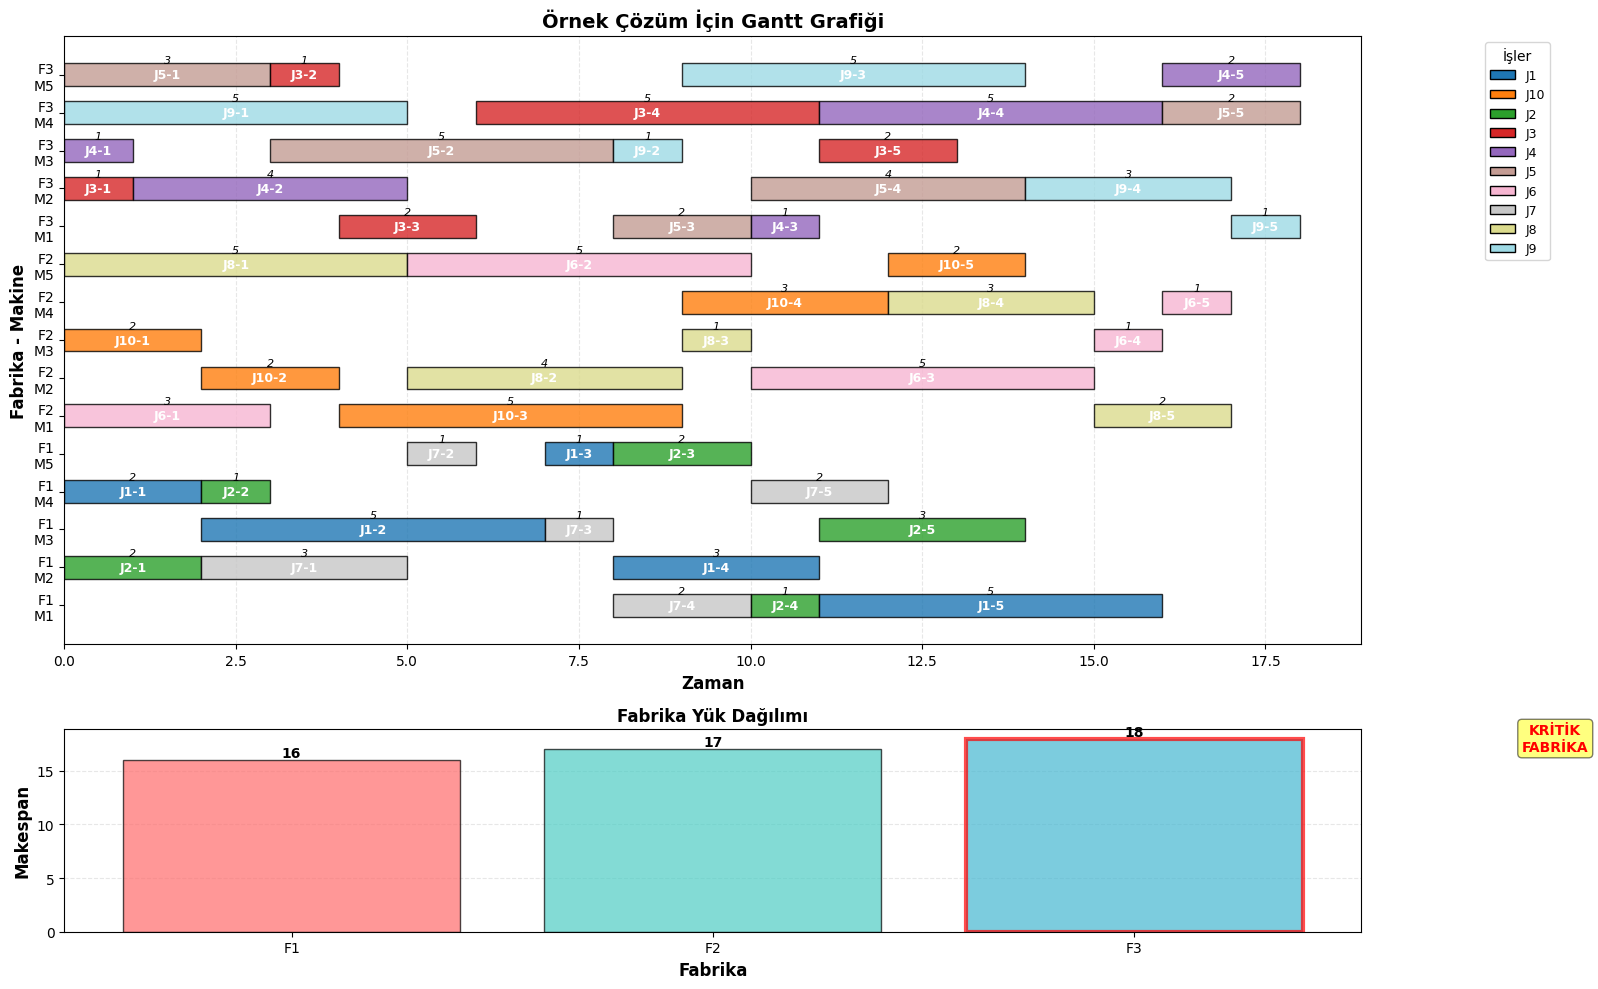

In [195]:
def select_candidates_for_tabu(population, num_candidates, elite_ratio=0.6):
    """Tabu arama için uygun adayları seçer"""
    sorted_pop = sorted(population, key=calculate_fitness)

    num_elite = int(num_candidates * elite_ratio)
    num_diverse = num_candidates - num_elite

    elites = sorted_pop[:num_elite]
    non_elites = sorted_pop[num_elite:]

    if len(non_elites) > num_diverse:
        diverse = random.sample(non_elites, num_diverse)
    else:
        diverse = non_elites

    candidates = elites + diverse
    return candidates

def improved_HGTSA():
    """Geliştirilmiş Hibrit Genetik Tabu Arama Algoritması"""
    population = create_initial_population()

    def best_individual(pop):
        return min(pop, key=calculate_fitness)

    xb = best_individual(population)
    best_fitness = calculate_fitness(xb)
    avg_fitness_history = []
    best_fitness_history = []
    TABU_CANDIDATE_RATIO = 0.20
    num_tabu_candidates = max(2, int(POPULATION_SIZE * TABU_CANDIDATE_RATIO))

    print("Geliştirilmiş Hibrit Genetik Tabu Arama algoritması başlatılıyor...")
    print(f"Başlangıç en iyi Cmax: {best_fitness}")
    print(f"Her jenerasyonda Tabu Arama uygulanacak birey sayısı: {num_tabu_candidates}")

    for gen in range(MAX_GENERATIONS):
        Q = []

        for _ in range(POPULATION_SIZE // 2):
            parent1 = roulette_wheel_selection(population)
            parent2 = roulette_wheel_selection(population)

            if random.random() < CROSSOVER_RATE:
                child1, child2 = crossover(parent1, parent2)
                Q.extend([child1, child2])
            else:
                Q.extend([deepcopy(parent1), deepcopy(parent2)])

        for i in range(len(Q)):
            if random.random() < MUTATION_RATE:
                Q[i] = mutation(Q[i])

        candidates = select_candidates_for_tabu(
            Q,
            num_candidates=num_tabu_candidates,
            elite_ratio=0.7
        )

        improved_candidates = []
        for candidate in candidates:
            improved_candidate = tabu_search(candidate)
            improved_candidates.append(improved_candidate)

        for candidate, improved in zip(candidates, improved_candidates):
            idx = Q.index(candidate)
            Q[idx] = improved

        population = Q

        xb_prime = best_individual(population)
        current_fitness = calculate_fitness(xb_prime)

        if current_fitness < best_fitness:
            xb = deepcopy(xb_prime)
            best_fitness = current_fitness
            print(f" Jenerasyon {gen+1:3d} | Yeni en iyi Cmax = {best_fitness}")

        if (gen + 1) % 10 == 0:
            avg_fitness = sum(calculate_fitness(ind) for ind in population) / len(population)
            print(f"Jenerasyon {gen+1:3d} | En iyi Cmax = {best_fitness} | Ortalama: {avg_fitness:.1f}")

    return xb, best_fitness

if __name__ == "__main__":

    try:
        Cmax_example, details_example = decoding_method(FA, OS, o_jm, p)
        crit_factory, factory_makespans = compute_critical_factory(details_example)

        print(f"Cmax: {Cmax_example}")
        print(f"Fabrika makespan'ları: {factory_makespans}")
        print(f"Kritik fabrika: {crit_factory}")

        print("GELİŞTİRİLMİŞ HGTSA ÇALIŞTIRILIYOR")
        start_time = time.time()
        best_solution, best_fitness = improved_HGTSA()

        print("SONUÇLAR")
        print(f"En iyi Cmax: {best_fitness}")
        print(f"Fabrika Ataması (FA): {best_solution['FA']}")
        print(f"Operasyon Sırası (OS): {best_solution['OS']}")

        Cmax_detail, solution_detail = decoding_method(
            best_solution["FA"],
            best_solution["OS"],
            o_jm,
            p
        )

        print(f"\nDoğrulanmış Cmax: {Cmax_detail}")

        improvement = ((Cmax_example - best_fitness) / Cmax_example) * 100
        print(f"\nİyileştirme: %{improvement:.2f}")

        crit_factory_best, factory_makespans_best = compute_critical_factory(solution_detail)
        print(f"En iyi çözümde kritik fabrika: {crit_factory_best}")
        print(f"Fabrika yük dağılımı: {factory_makespans_best}")
        end_time = time.time()
        execution_time = end_time - start_time
        print("ÇALIŞMA ZAMANI SONUÇLARI")
        print(f"Toplam Çalışma Süresi: {execution_time/60:.2f} dakika")
        print(f"Örnek Çözüm Makespan: {Cmax_example}")
        print("\n Gantt Grafiği çiziliyor...")
        df = plot_detailed_gantt_chart(solution_detail,
                                      title="Örnek Çözüm İçin Gantt Grafiği")
    except Exception as e:
        print(f"Hata oluştu: {e}")
        import traceback
        traceback.print_exc()